In [1]:
# install.packages("igraph")
# install.packages("tidygraph")

## Traversing graphs with tidygraph in R

Raphael Leung 

The Indexing and Data Management Section (IDMS) in the House of Commons Library keeps a taxonomy/ controlled vocabulary of subject topics. Parliamentary stuff is regularly tagged against this taxonomy.

We want the taxonomy to more closely adhere to Simple Knowledge Organization System (SKOS). [SKOS](https://www.w3.org/TR/2009/REC-skos-reference-20090818/) is an RDF-based model for simple knowledge structures like thesauri/ controlled vocabularies. It lets you organize your concepts into informal hierarchies and association networks, document and annotate them, link them to other concepts, group them into collections..., importantly, in a way that let's others outside your domain know what you're doing (because SKOS's a W3C recommendation). SKOS can be extended, too (i.e. [“Not take it or leave it, but take what you want, make what you need"](http://dublincore.org/resources/training/frd_20091217/Tutorial_FRD_baker-4.pdf).) Other open linked data vocabularies you may have heard of include Dublin Core for metadata terms.

If you're new to semantic web technologies, linked data vocabularies basically encourage vocabulary re-use across the Web, so you have a web of broader and narrower concepts. Core idea is to enable wider re-use and better interoperability.

Anyway, there're these taxonomies that have been maintained for a long time internally but not closely analyzed. They are used for indexing. They evolve and are manually curated. They have hierarchies (e.g. broader, narrower terms). Would be nice to have a closer look...

This uses `tidyraph` in R to do so. It has `igraph` under the hood combined with `dplyr` syntax.

First, fetch the terms from http://lda.data.parliament.uk/terms and load in the csv.

In [4]:
terms_labels <- read.csv("terms_labels.csv", header=TRUE)
head(terms_labels)

X,uri,broader,broader...uri,narrower,narrower...uri,pref.label,type,type...uri,class
1,http://data.parliament.uk/terms/347260,91822,http://data.parliament.uk/terms/91822,NA,http://data.parliament.uk/terms/347135,Acts,,http://www.w3.org/2004/02/skos/core#Concept,CTP
2,http://data.parliament.uk/terms/347260,91822,http://data.parliament.uk/terms/91822,NA,http://data.parliament.uk/terms/352234,Acts,Concept,http://www.w3.org/2004/02/skos/core#Concept,CTP
3,http://data.parliament.uk/terms/90131,90829,http://data.parliament.uk/terms/90829,NA,,Adjournment debates,,http://www.w3.org/2004/02/skos/core#Concept,CTP
4,http://data.parliament.uk/terms/347012,347010,http://data.parliament.uk/terms/347010,NA,http://data.parliament.uk/terms/347014,Adopted legislation,,http://www.w3.org/2004/02/skos/core#Concept,CTP
5,http://data.parliament.uk/terms/347012,347010,http://data.parliament.uk/terms/347010,NA,http://data.parliament.uk/terms/347016,Adopted legislation,Concept,http://www.w3.org/2004/02/skos/core#Concept,CTP
6,http://data.parliament.uk/terms/347012,347010,http://data.parliament.uk/terms/347010,NA,http://data.parliament.uk/terms/347018,Adopted legislation,Concept,http://www.w3.org/2004/02/skos/core#Concept,CTP


### Clean up the data

This uses `dplyr` (with piping syntax imported from `magrittr`) in tidyverse which mostly makes nested function calls look cleaner and more readable.

In [5]:
library(dplyr)

terms_labels$uri %<>% as.character() %>% strsplit("/", fixed=TRUE) %>% sapply(tail, 1)
terms_labels$narrower...uri %<>% as.character() %>% strsplit("/", fixed=TRUE) %>% sapply(tail, 1) %>% sapply(function(x) if(identical(x,character(0))) NA else x)
terms_labels$broader...uri %<>% as.character() %>% strsplit("/", fixed=TRUE) %>% sapply(tail, 1) %>% sapply(function(x) if(identical(x,character(0))) NA else x)
terms_labels %<>% select(uri,broader...uri,narrower...uri,pref.label,class) %>% rename(ID=uri,broader_ID=broader...uri,narrower_ID=narrower...uri,idmsClass=class) %>% transform(ID = as.numeric(ID), broader_ID = as.numeric(broader_ID), narrower_ID = as.numeric(narrower_ID), pref.label = as.character(pref.label), idmsClass = as.character(idmsClass))
head(terms_labels)

Warning message in eval(substitute(list(...)), `_data`, parent.frame()):
“NAs introduced by coercion”

ID,broader_ID,narrower_ID,pref.label,idmsClass
347260,91822,347135,Acts,CTP
347260,91822,352234,Acts,CTP
90131,90829,NA,Adjournment debates,CTP
347012,347010,347014,Adopted legislation,CTP
347012,347010,347016,Adopted legislation,CTP
347012,347010,347018,Adopted legislation,CTP


### Convert to edgelist 

I should note that, natively, the data exposed on lda.data.parliament.uk is in RDF format, a type of graph. However, there aren't many good packages that loads RDF data into R. (There's `SPARQL`, `redland`, `rrdf` R packages which are maintained to various degrees.) There is a hacky way to run SPARQL on the site but it's not an actively developed-on service and large payloads often throw up errors. The terms data was thus exported into relational/ tabular shape as a CSV, and after cleaning, looks like it does above. So it's worth noting that `tidygraph` graph objects more closely follow the property graph model (nodes and edges have properties) rather than RDF.

The tabular data above isn't yet a graph data structure. Common graph data structures/ representations include edgelists, adjacency/incidence matrices, and adjacency lists. 

The next step converts it to an edgelist. Cocept A is broader than Concept B is represented by an edge from A to B.

If you're into network analysis, the key things to note are the graph is directed/ asymmetric, unweighted, and one-mode. ("One-mode" because both "from" and "to" are the same type of actor, here concepts. For a less simple graph, can also treat IDMS-defined classes (CTP, TPG, ORG etc) as an edge property. Since concepts are shared between classes, this would make the graph multiplex, i.e. multiple relations between the same actors, instead of uniplex. Since the taxonomies evolve, we can also bring in time to make this a dynamic/ time-dependent instead of cross-sectional. But let's start with the simplest form.)

In [6]:
terms_labels_subclass <- terms_labels %>% filter(idmsClass=="TPG")
broader <- terms_labels_subclass %>% subset(select=c("broader_ID", "ID")) %>% na.omit() %>% unique() %>% rename(from=broader_ID,to=ID)
narrower <- terms_labels_subclass %>% subset(select=c("ID", "narrower_ID")) %>% na.omit() %>% unique() %>% rename(from=ID,to=narrower_ID)
edgelist <- broader %>% rbind(narrower) %>% unique()
head(edgelist)

,from,to
1,95539,95476
3,95563,95477
4,95575,95477
5,95497,95478
6,95678,95478
7,95645,95479


As you can see, I subset the data to just the smallest and most intuitive taxonomy, TPG (which stands for "topic page"...) If you're interested in the story, these topics can be traced to the current website at http://parliament.uk/topics/topical-issues.htm, though that has been a graveyard of weblinks for the past few years and will eventually be replaced on https://beta.parliament.uk.

We'll look at all of the IDMS-defined classes at the end.

### Load into `tidygraph`

`tidygraph` is a fairly [new entry](https://www.data-imaginist.com/2017/introducing-tidygraph/) into the tidyverse in 2017. So it has `dplyr` verbs and `magrittr` pipes. `tidygraph` adds more graph algorithms and visualizations to its underlying `igraph`, which is an open-source network analysis package available in R, Python and C, [docs here](http://igraph.org/).

In [9]:
library(tidygraph)
library(igraph)
g <- edgelist %>% as_tbl_graph(directed=TRUE)
g
print(paste0("# of edges: ",  gsize(g)," | # of nodes: ", gorder(g), " | # of weakly connected components: ", length(decompose(g, mode="weak"))))

# A tbl_graph: 314 nodes and 357 edges
#
# A directed acyclic simple graph with 1 component
#
# Node Data: 314 x 1 (active)
  name 
  <chr>
1 95539
2 95563
3 95575
4 95497
5 95678
6 95645
# ... with 308 more rows
#
# Edge Data: 357 x 2
   from    to
  <int> <int>
1     1    43
2     2    70
3     3    70
# ... with 354 more rows

[1] "# of edges: 357 | # of nodes: 314 | # of weakly connected components: 1"


### Render the graph

In [10]:
options(repr.plot.width=10, repr.plot.height=10)
g %>% plot(layout=layout.fruchterman.reingold, vertex.size=degree(g)*0.6, vertex.label.color="darkblue", vertex.label.cex=0.6, vertex.color="orange", edge.arrow.size=0.1, edge.width=0.5, edge.color="gray")

### Pick a graph traversal algorithm - what's BFS/DFS?

`tidygraph` lets you add properties to nodes and edges with `mutate`, the `dplyr` verb to create new columns. E.g. `g %>% activate(nodes) %>% mutate(name = as.numeric(name))` activates the nodes and turn them from characters to numerics. This [blog](https://www.data-imaginist.com/2017/introducing-tidygraph/) gives a great overview of functionality of the package in addition to the [docs](https://cran.r-project.org/web/packages/tidygraph/tidygraph.pdf).

Now here's the exciting part -- graph traversal! Let's make an example graph.

(Less excitingly, `nbviewer` currently has trouble rendering image/svg+xml 😐 so we'll have to make do with a static image)

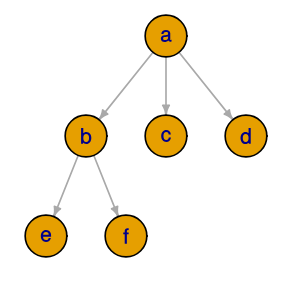

In [18]:
options(repr.plot.width=5, repr.plot.height=4)
example <- create_tree(6, children=3) %>% mutate(name = letters[1:6]) 
# example %>% plot(layout=layout.reingold.tilford,vertex.label.cex=1, vertex.size=40)
library(IRdisplay)
display_png(file="igraphTraversalExample.PNG")

There are two main ways of traversing it: breadth-first search (BFS) and depth-first search (DFS). Both require specifying an entry point or the root node.
* BFS: Go a level at a time, until all nodes in that level have been reached, then continue to next level. 
    * a &rarr; b &rarr; c &rarr; d &rarr; e &rarr; f
* DFS: Go as deep as possible along each branch then backtracking upwards
    * a &rarr; b &rarr; e &rarr; f &rarr; c &rarr; d (preorder; there are other orderings)

BFS uses a queue and DFS uses a stack. A queue is horizontal, like a restaurant queue, it's first-in-first-out/ last-in-last-out (FIFO/ LILO). Main operations are enqueue and dequeue. A stack is vertical, like a stack of food trays, it's first-in-last-out/ last-in-first-out (FILO/ LIFO). Main operations are push and pop. This [IDEA assembly instructions](https://idea-instructions.com/graph-scan/) illustrates it in a fun way...

You can implement queue and stack functionalities with e.g linked lists.

The relative complexity of both DFS and BFS is $O(E + V)$, because you vist every edge and node in worst case. So whichever larger term dominates. If graphs's really dense, $|E|$ can be as high as $|V|^2$, so $E$ dominates and complexity is $O(E)$. For a sparse graph where $E$<$V$ then complexity is $O(V)$.

In [11]:
example %>% mutate(before = map_bfs_int(node_is_root(), .f = function(rank, ...) {
rank
})) 

# A tbl_graph: 6 nodes and 5 edges
#
# A rooted tree
#
# Node Data: 6 x 2 (active)
  name  before
  <chr>  <int>
1 a          1
2 b          2
3 c          3
4 d          4
5 e          5
6 f          6
#
# Edge Data: 5 x 2
   from    to
  <int> <int>
1     1     2
2     1     3
3     1     4
# ... with 2 more rows

In [12]:
example %>% mutate(before = map_dfs_int(node_is_root(), .f = function(rank, ...) {
rank
})) 

# A tbl_graph: 6 nodes and 5 edges
#
# A rooted tree
#
# Node Data: 6 x 2 (active)
  name  before
  <chr>  <int>
1 a          1
2 b          2
3 c          5
4 d          6
5 e          3
6 f          4
#
# Edge Data: 5 x 2
   from    to
  <int> <int>
1     1     2
2     1     3
3     1     4
# ... with 2 more rows

We can see the orders in which the nodes do indeed adhere to the explanation above.

### Back to our taxonomy graph...

Now that we know what BFS and DFS is, let's return to the indexing taxonomy.

One thing we can use the traversal algorithms for is to get the depth of each node. Depth of a node = the number of edges from the node to the tree's root node. Depth is generally useful to obtain because, e.g. here, we can then know how far down the taxonomy an indexer went to pick the subject tag. 

Instead of returning the depth per node, can also do calculations/ return metrics of centrality/ finding paths, etc. There're many, many applications of traversal algorithms!

Here, we can add a property called "dist" to the nodes, calling `bfs_dist()` and passing in a `tbl_graph` object and specifying its root. `bfs_dist()` gets the number of nodes between the root and each node in a bredth ﬁrst search. 

But, how do we find the entry point/ root of the graph?

In [13]:
which(V(g) %>% sapply(function(x) neighbors(g,x,mode="in")) %>% sapply(length) == 0)

95475 
   10

In [14]:
g %>% mutate(dist = bfs_dist(
    which(V(g) %>% sapply(function(x) neighbors(g,x,mode="in")) %>% sapply(length) == 0)
                          ))

# A tbl_graph: 314 nodes and 357 edges
#
# A directed acyclic simple graph with 1 component
#
# Node Data: 314 x 2 (active)
  name   dist
  <chr> <int>
1 95539     1
2 95563     1
3 95575     1
4 95497     2
5 95678     2
6 95645     1
# ... with 308 more rows
#
# Edge Data: 357 x 2
   from    to
  <int> <int>
1     1    43
2     2    70
3     3    70
# ... with 354 more rows

### Lets's get the depth for all nodes

The root can be determined by passing all nodes into `neighbors()` function in igraph, to check which node has zero incoming edges, which in a one-component graph, makes it the root node. But that isn't very efficient -- there are 2 `sapply`s (applies that return vectors). 

The following tries to do the same in a more efficient way...

In [15]:
g %>% mutate(neighborhood_in_edges = map_local_dbl(mode="in", .f = function(neighborhood, ...) {
    gsize(neighborhood)
    })) %>% mutate(dist = bfs_dist(which(neighborhood_in_edges==0))) %>% arrange(neighborhood_in_edges)

# A tbl_graph: 314 nodes and 357 edges
#
# A directed acyclic simple graph with 1 component
#
# Node Data: 314 x 3 (active)
  name  neighborhood_in_edges  dist
  <chr>                 <dbl> <int>
1 95475                     0     0
2 95539                     1     1
3 95563                     1     1
4 95575                     1     1
5 95497                     1     2
6 95678                     1     2
# ... with 308 more rows
#
# Edge Data: 357 x 2
   from    to
  <int> <int>
1     2    41
2     3   278
3     4   278
# ... with 354 more rows

### And a quick check to see if it's right

For hierarchical graphs like taxonomies, a good visual check is plotting the graph in Reingold & Tilford’s Tidier layout. 

In [19]:
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow = c(1, 2))
g %>% plot(layout=layout.kamada.kawai,vertex.size=degree(g)*1.2, vertex.label.color="darkblue", vertex.label.cex=0.6, vertex.color="orange", edge.arrow.size=0.1, edge.width=0.5, edge.color="gray")
mtext("Kamada Kawai layout") 
g %>% plot(layout=layout.reingold.tilford, vertex.size=10, vertex.label.color="darkblue", vertex.label.cex=0.6, vertex.color="orange", edge.arrow.size=0.2, edge.width=1, edge.color="darkgray")
mtext("Reingold & Tilford’s Tidier layout") 

We see the root node is indeed 95475, which according to http://lda.data.parliament.uk/terms/95475, is "Taxonomy". That node leads to 20 nodes in the first layer (with distance 1), and more in the layer below. To see actual labels of the taxons, I made a d3 version too that's more human-friendly: https://bl.ocks.org/lcyraphael/421f3f14854cb49a8fd199f9e326ecaa.

### Now for the rest of the graphs

In [22]:
class_names = c("CTP", "NAME", "ID", "LEG", "SIT", "TPG", "ORG")
results = data.frame()

for(i in class_names){
    
    terms_labels_subclass <- terms_labels %>% filter(idmsClass==i)
    broader <- terms_labels_subclass %>% subset(select=c("broader_ID", "ID")) %>% na.omit() %>% unique() %>% rename(from=broader_ID,to=ID)
    narrower <- terms_labels_subclass %>% subset(select=c("ID", "narrower_ID")) %>% na.omit() %>% unique() %>% rename(from=ID,to=narrower_ID)
    edgelist <- broader %>% rbind(narrower) %>% unique()
    g <- edgelist %>% as_tbl_graph(directed=TRUE)
    
    numVertex <- gorder(g)
    numEdge <- gsize(g)
    numComponents <- length(decompose(g, mode="weak"))
    
    if(numComponents == 1) {
        indegree <- V(g) %>% sapply(function(x) neighbors(g,x,mode="in")) %>% sapply(length)
        root <- names(which(indegree == 0))
    }
    else {
        root = NA
    }
    
    row <- data.frame(i, numVertex, numEdge, numComponents, root)
    results <- rbind(results, row)
}

colnames(results) <- c("Class", "Vertices", "Edges", "Components", "Root")
results

Class,Vertices,Edges,Components,Root
CTP,147,151,1,346696
NAME,6985,6983,2,NA
ID,7889,7798,509,NA
LEG,7509,7508,1,287813
SIT,6315,6949,1,90102
TPG,314,357,1,95475
ORG,47096,47694,17,NA


Note we can still run DFS/BFS on graphs with more than 1 component. With the example of `map_[bd]fs_*()` in tidygraph, set unreachable to `TRUE` so the search jumps to an unvisited node if the search is completed without visiting all nodes.

But e.g. ID class graph are more of a curated flat list without much hierarchy. So it's generally worth sanity-checking first before passing a graph into the algorithm.

Happy graph traversing! 🕸️🏃